In [ ]:
#import the needed Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image
import pandas as pd

from IPython import display
import cv2
import pickle


import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the DataFrame which includes the path and label
df_data = pd.read_csv('/content/drive/MyDrive/AML/Challenge1/dataset/train.csv')  # Adjust path as needed
data_dir = '/content/drive/MyDrive/AML/Challenge1/dataset/train/train/'

# Filter out images without a cactus
df_data = df_data[df_data['has_cactus'] == 1]

df_data.shape

(13136, 2)

In [ ]:
df_data

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17493,ffeafc3bd716a83bc93014fdb0ef53fa.jpg,1
17494,ffed5c4d70e58d53fbba6e92570371ef.jpg,1
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1


In [ ]:
# @title done in my machine bc google badwith disk sucks

# images = []
# labels = []

# # Load images and their labels
# for img_name, label in tqdm(df_data.values, total=df_data.shape[0], desc="Loading images"):
#     img_path = os.path.join(data_dir, img_name)
#     if os.path.exists(img_path):  # Check if the image file exists
#         image = cv2.imread(img_path)
#         if image is not None:
#             images.append(image)
#             labels.append(label)
#         else:
#             print(f"Failed to load image: {img_path}")  # Feedback if an image cannot be loaded
#     else:
#         print(f"File not found: {img_path}")  # Feedback if file path is incorrect

# # Convert lists to numpy arrays
# images = np.array(images)

# # Normalize pixel values to be between 0 and 1
# images = images.astype('float32') / 255

In [ ]:
with open('/content/drive/MyDrive/AML/Challenge1/dataset/images_0.pickle', 'rb') as f:
    images_1 = pickle.load(f)

In [ ]:
# with open('/content/drive/MyDrive/AML/Challenge1/dataset/images.pickle', 'rb') as f:
#     images = pickle.load(f)
with open('/content/drive/MyDrive/AML/Challenge1/dataset/images.pickle', 'rb') as f:
    images = pickle.load(f)


# Shuffle the dataset
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]

# Split into training and test sets
train_images, test_images = np.split(images, [int(0.8 * len(images))])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images)).batch(64)


# # Calculate split indices
# train_size = int(0.7 * len(images))
# validation_size = int(0.15 * len(images)) + train_size

# # Split into training, validation, and test sets
# train_images = images[:train_size]
# validation_images = images[train_size:validation_size]
# test_images = images[validation_size:]

# # Create TensorFlow datasets
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(64)
# validation_dataset = tf.data.Dataset.from_tensor_slices(validation_images).shuffle(len(validation_images)).batch(64)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images)).batch(64)

# # Check the size of each dataset
# print("Training set size: ", len(train_images))
# print("Validation set size: ", len(validation_images))
# print("Testing set size: ", len(test_images))

In [ ]:
# Check the size of each dataset
print("Training set size: ", len(train_images))
# print("Validation set size: ", len(validation_images))
print("Testing set size: ", len(test_images))

Training set size:  10508
Testing set size:  2628


In [ ]:
#create a write
writer = tf.summary.create_file_writer('./new_loss')

In [ ]:
#@title with dropout

# class CVAE(tf.keras.Model):
#     def __init__(self, latent_dim, dropout_rate=0.5):  # Adding a dropout_rate parameter with a default of 0.5
#         super(CVAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.inference_net = tf.keras.Sequential(
#           [
#               tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
#               tf.keras.layers.Conv2D(
#                   filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after convolution
#               tf.keras.layers.Conv2D(
#                   filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after convolution
#               tf.keras.layers.Conv2D(
#                   filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
#               tf.keras.layers.Flatten(),
#               tf.keras.layers.Dense(latent_dim + latent_dim),
#           ]
#         )

#         self.generative_net = tf.keras.Sequential(
#             [
#               tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
#               tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after dense layer
#               tf.keras.layers.Reshape(target_shape=(16,16, 32)),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=64,
#                   kernel_size=3,
#                   strides=(2, 2),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=64,
#                   kernel_size=3,
#                   strides=(1, 1),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=128,
#                   kernel_size=3,
#                   strides=(1, 1),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'),
#             ]
#         )
#     @tf.function
#     def sample(self, eps=None):
#         if eps is None:
#             eps = tf.random.normal(shape=(64, self.latent_dim))
#         return self.decode(eps, apply_sigmoid=True)

#     def encode(self, x):   #encode the images into the latent space
#         mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
#         return mean, logvar

#     #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
#     #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it
#     #by the latent distribution's variance 'rho'.

#     def reparameterize(self, mean, logvar):
#         eps = tf.random.normal(shape=mean.shape)
#         return eps * tf.exp(logvar * .5) + mean

#     def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
#         logits = self.generative_net(z)
#         if apply_sigmoid:
#             probs = tf.sigmoid(logits)
#             return probs
#         return logits


In [ ]:
#@title without dropout
#The Convolutional Variational Auto-Encoder Proper.
#Define the network class

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):   #latent_dim is the dimensional of the latent space
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),   #Note Input Image Size
              tf.keras.layers.Conv2D(
                  filters=16, kernel_size=3,activation='relu',padding='same'),
              tf.keras.layers.Conv2D(
                  filters=16, kernel_size=3, activation='relu',padding='same'),
              # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),


              tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
              # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

              tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
              tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
              # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(8,8, 32)), #Note the strides formula!
              tf.keras.layers.Conv2DTranspose(
                  filters=32,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=128,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=256,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=3, kernel_size= 3, strides=(1, 1), padding="SAME", activation='sigmoid'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    kl_tolerance = 0.2
    #import pdb; pdb.set_trace()
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
    kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * latent_dim))
    loss_sum = reconstruction_loss + kl_loss

    with writer.as_default():
        tf.summary.scalar('Graph of' + '_reconstruction_loss', reconstruction_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_kl_loss', kl_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_loss_sum',loss_sum, step=epoch)
        writer.flush()
    return loss_sum, reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, r_loss, kl_loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return r_loss, kl_loss

In [ ]:
# @tf.function
# def compute_loss(model, x):
#     #...
#     reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
#     kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
#     loss_sum = reconstruction_loss + kl_loss

#     #Compute additional metrics
#     mahalanobis_distance = tf.linalg.mahalanobis_distance(z, mean, logvar)
#     likelihood_ratio = tf.probability.likelihood_ratio(z, mean, logvar)
#     wasserstein_distance = tf.linalg.wasserstein_distance(z, mean, logvar)

#     return loss_sum, reconstruction_loss, kl_loss, mahalanobis_distance, likelihood_ratio, wasserstein_distance


In [ ]:
epochs = 100
latent_dim = 256#was 128 before
num_examples_to_generate = 12#was 12 before

In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [ ]:
model.built = True

In [ ]:
from keras.utils import plot_model

# Assuming your model instance is named 'model'
# Plot the inference network
plot_model(model.inference_net, to_file='inference_net.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Plot the generative network
plot_model(model.generative_net, to_file='generative_net.png', show_shapes=True, show_layer_names=True)

In [ ]:
# def generate_and_save_images(model, epoch, test_input):
#     predictions = model.sample(test_input)
#     fig = plt.figure(figsize=(16,16))

#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
#         plt.axis('off')

#     # tight_layout minimizes the overlap between 2 sub-plots
#     plt.savefig('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch__24vec{:04d}.png'.format(epoch))
#     plt.show()
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)  # Assuming this returns the images to plot

    plt.figure(figsize=(10, 10))  # Creating a figure large enough to hold all subplots

    # Ensure we do not attempt to plot more images than we have subplots for
    num_images = predictions.shape[0]
    max_images = 16  # As you seem to be setting up a 4x4 grid
    num_images = min(num_images, max_images)

    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0])  # Adjust indexing if needed based on data format
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch_new_Nocactus_2{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
def test_image(latent_dim,test_img):
    test_img = test_img.reshape(1,32,32,3)   #Note the Image size here
    model = CVAE(latent_dim)
    encod, logvar = model.encode(test_img)
    repar = model.reparameterize(encod, logvar)
    img = model.decode(repar)
    img *= 255.
    img = np.squeeze(img)
    return plt.imshow(img)

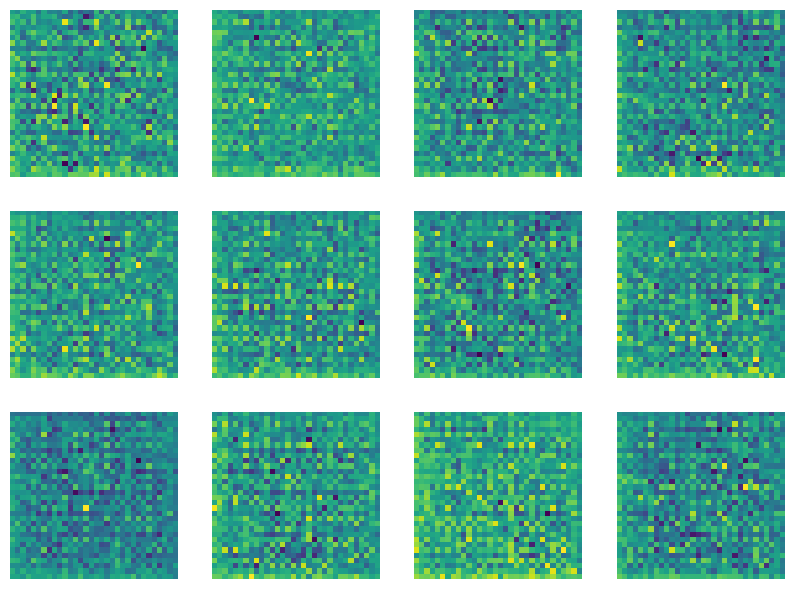

Epoch: 1, reconstruction_loss: 55.971580505371094, kl_loss: 51.416542053222656
Epoch: 1, Test set LOSS_sum: 97.76041412353516, reconstruction_loss: 46.19435119628906, kl_loss: 51.56605911254883
Checkpoint saved at Epoch 1: Improved reconstruction_loss and kl_loss.
Epoch: 2, reconstruction_loss: 41.845603942871094, kl_loss: 51.36232376098633
Epoch: 2, Test set LOSS_sum: 94.23876953125, reconstruction_loss: 42.98407745361328, kl_loss: 51.254695892333984
Checkpoint saved at Epoch 2: Improved reconstruction_loss and kl_loss.
Epoch: 3, reconstruction_loss: 39.662254333496094, kl_loss: 51.34597396850586
Epoch: 3, Test set LOSS_sum: 90.07032775878906, reconstruction_loss: 38.640838623046875, kl_loss: 51.42951202392578
Checkpoint saved at Epoch 3: Improved reconstruction_loss and kl_loss.
Epoch: 4, reconstruction_loss: 37.86178970336914, kl_loss: 51.3438606262207
Epoch: 4, Test set LOSS_sum: 87.92745971679688, reconstruction_loss: 36.619834899902344, kl_loss: 51.30760955810547
Checkpoint saved

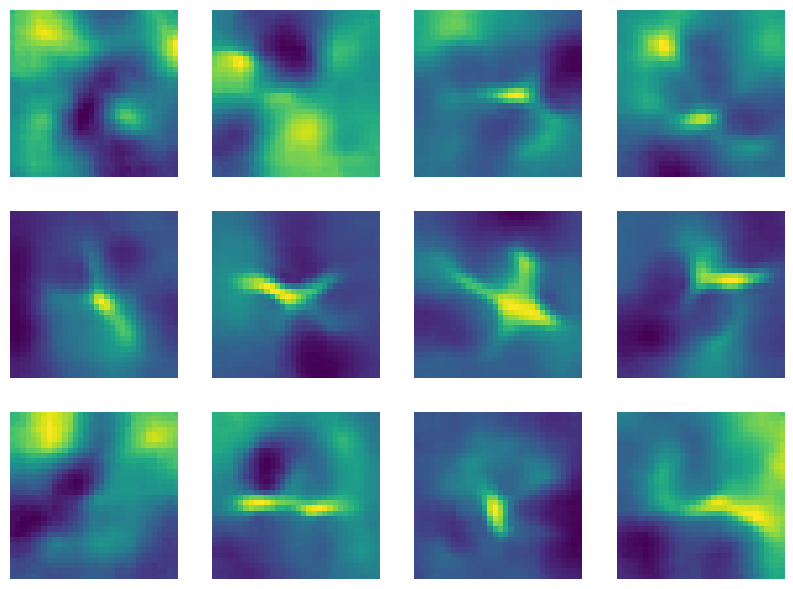

Epoch: 11, reconstruction_loss: 32.02950668334961, kl_loss: 51.30829620361328
Epoch: 11, Test set LOSS_sum: 82.83018493652344, reconstruction_loss: 31.30864906311035, kl_loss: 51.52153015136719
Checkpoint saved at Epoch 11: Improved reconstruction_loss and kl_loss.
Epoch: 12, reconstruction_loss: 31.52845001220703, kl_loss: 51.311683654785156
Epoch: 12, Test set LOSS_sum: 82.75753021240234, reconstruction_loss: 31.43610191345215, kl_loss: 51.321441650390625
Epoch: 13, reconstruction_loss: 31.221025466918945, kl_loss: 51.31114959716797
Epoch: 13, Test set LOSS_sum: 82.60774230957031, reconstruction_loss: 31.387229919433594, kl_loss: 51.22049331665039
Epoch: 14, reconstruction_loss: 30.92327117919922, kl_loss: 51.30617904663086
Epoch: 14, Test set LOSS_sum: 82.09503173828125, reconstruction_loss: 30.78749656677246, kl_loss: 51.307525634765625
Checkpoint saved at Epoch 14: Improved reconstruction_loss and kl_loss.
Epoch: 15, reconstruction_loss: 30.83243751525879, kl_loss: 51.308429718017

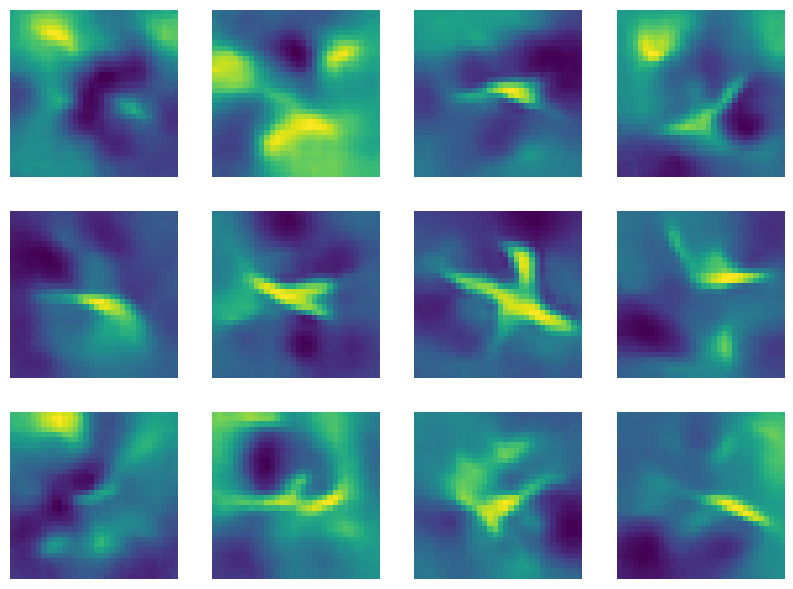

Epoch: 21, reconstruction_loss: 29.608549118041992, kl_loss: 51.3040771484375
Epoch: 21, Test set LOSS_sum: 81.48566436767578, reconstruction_loss: 30.072147369384766, kl_loss: 51.41353225708008
Epoch: 22, reconstruction_loss: 29.52577018737793, kl_loss: 51.30496597290039
Epoch: 22, Test set LOSS_sum: 81.19593811035156, reconstruction_loss: 29.87677574157715, kl_loss: 51.31916809082031
Epoch: 23, reconstruction_loss: 29.4132022857666, kl_loss: 51.30218505859375
Epoch: 23, Test set LOSS_sum: 81.58436584472656, reconstruction_loss: 30.173017501831055, kl_loss: 51.41133499145508
Epoch: 24, reconstruction_loss: 29.255634307861328, kl_loss: 51.297950744628906
Epoch: 24, Test set LOSS_sum: 80.8005142211914, reconstruction_loss: 29.44362449645996, kl_loss: 51.35688781738281
Checkpoint saved at Epoch 24: Improved reconstruction_loss and kl_loss.
Epoch: 25, reconstruction_loss: 29.04947853088379, kl_loss: 51.2987174987793
Epoch: 25, Test set LOSS_sum: 80.78057098388672, reconstruction_loss: 29.

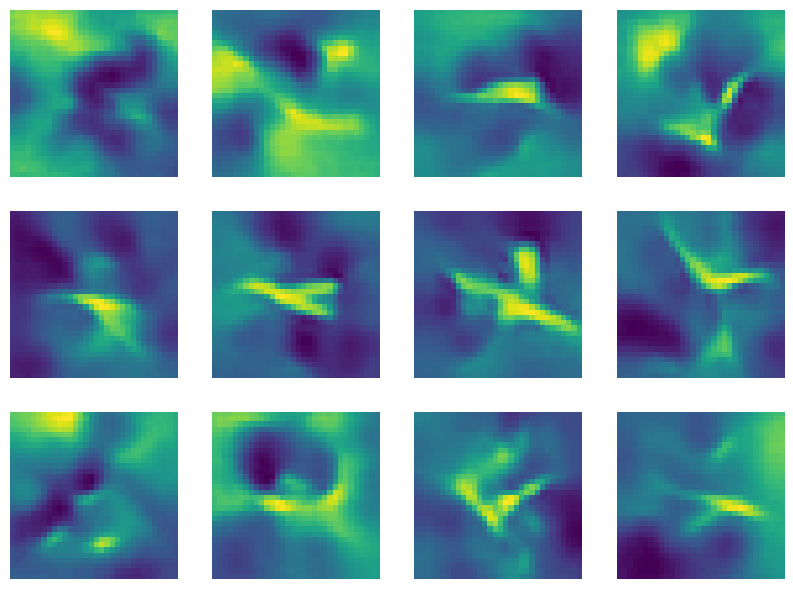

Epoch: 31, reconstruction_loss: 28.60228157043457, kl_loss: 51.29283142089844
Epoch: 31, Test set LOSS_sum: 81.21796417236328, reconstruction_loss: 29.88094139099121, kl_loss: 51.3370361328125
Epoch: 32, reconstruction_loss: 28.54817771911621, kl_loss: 51.29179763793945
Epoch: 32, Test set LOSS_sum: 80.55207824707031, reconstruction_loss: 29.181507110595703, kl_loss: 51.37055969238281
Epoch: 33, reconstruction_loss: 28.50616455078125, kl_loss: 51.299442291259766
Epoch: 33, Test set LOSS_sum: 80.17655181884766, reconstruction_loss: 28.679922103881836, kl_loss: 51.49662399291992
Checkpoint saved at Epoch 33: Improved reconstruction_loss and kl_loss.
Epoch: 34, reconstruction_loss: 28.3841495513916, kl_loss: 51.28526306152344
Epoch: 34, Test set LOSS_sum: 80.32936096191406, reconstruction_loss: 28.5483341217041, kl_loss: 51.7810173034668
Checkpoint saved at Epoch 34: Improved reconstruction_loss and kl_loss.
Epoch: 35, reconstruction_loss: 28.34513282775879, kl_loss: 51.29440689086914
Epo

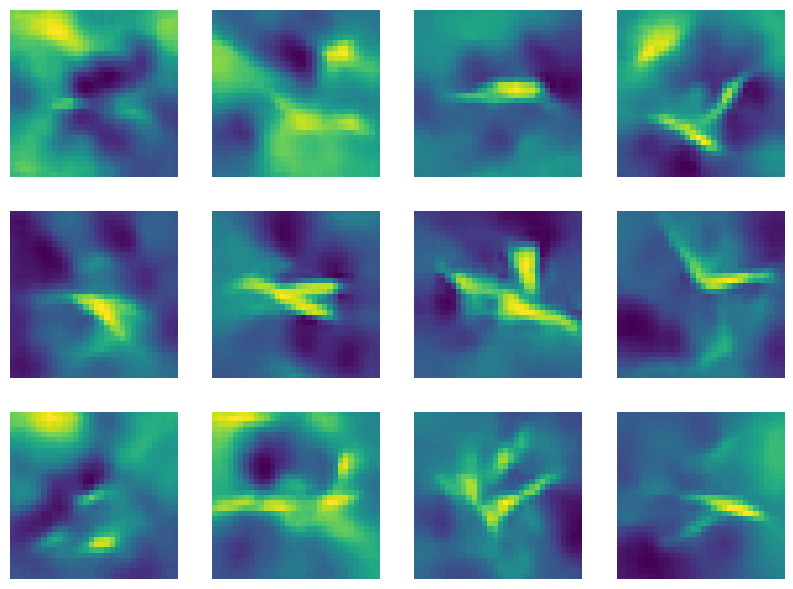

Epoch: 41, reconstruction_loss: 27.98851776123047, kl_loss: 51.29016876220703
Epoch: 41, Test set LOSS_sum: 79.9283218383789, reconstruction_loss: 28.6575927734375, kl_loss: 51.27071762084961
Epoch: 42, reconstruction_loss: 27.84432029724121, kl_loss: 51.2907600402832
Epoch: 42, Test set LOSS_sum: 79.82688903808594, reconstruction_loss: 28.420475006103516, kl_loss: 51.40641403198242
Checkpoint saved at Epoch 42: Improved reconstruction_loss and kl_loss.
Epoch: 43, reconstruction_loss: 27.904281616210938, kl_loss: 51.286903381347656
Epoch: 43, Test set LOSS_sum: 79.737060546875, reconstruction_loss: 28.389877319335938, kl_loss: 51.34716033935547
Checkpoint saved at Epoch 43: Improved reconstruction_loss and kl_loss.
Epoch: 44, reconstruction_loss: 27.84578514099121, kl_loss: 51.28855895996094
Epoch: 44, Test set LOSS_sum: 79.8042984008789, reconstruction_loss: 28.38509178161621, kl_loss: 51.4192008972168
Checkpoint saved at Epoch 44: Improved reconstruction_loss and kl_loss.
Epoch: 45, 

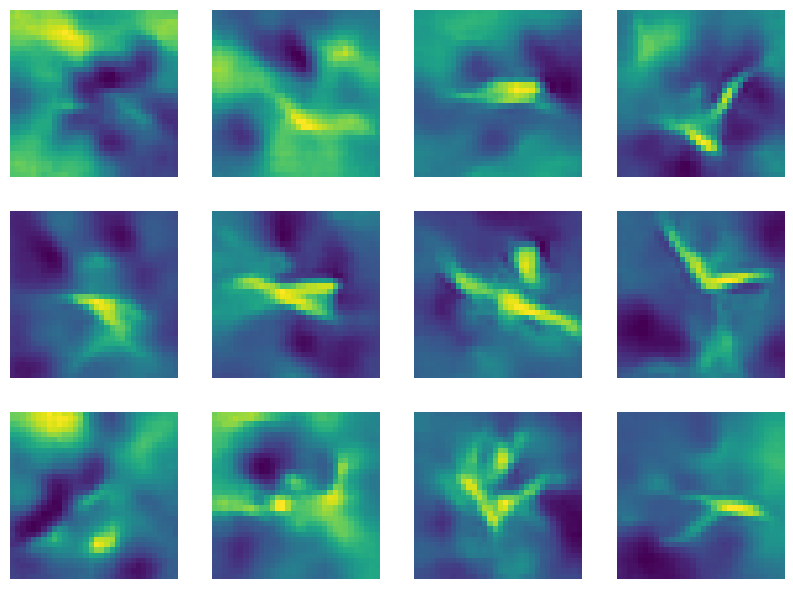

Epoch: 51, reconstruction_loss: 27.621768951416016, kl_loss: 51.29761505126953
Epoch: 51, Test set LOSS_sum: 80.1742935180664, reconstruction_loss: 28.890636444091797, kl_loss: 51.28364944458008
Epoch: 52, reconstruction_loss: 27.6508731842041, kl_loss: 51.28663635253906


KeyboardInterrupt: 

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)
loss_logs_df_columns = ['epoch','loss_sum', 'reconstruction_loss', 'kl_loss']
loss_logs_df=pd.DataFrame(columns=loss_logs_df_columns)
loss_logs_df_train_columns = ['epoch','reconstruction_loss', 'kl_loss']
loss_logs_df_train=pd.DataFrame(columns=loss_logs_df_train_columns)
best_rec_valid = float('inf')
best_kl_valid = float('inf')

for epoch in range(1, epochs + 1):
    loss_list_train = []
    loss_train, rec_train, kl_train = 0, 0, 0
    for train_x in train_dataset:
        r_loss, kl_loss = compute_apply_gradients(model, train_x, optimizer)
        rec_train += r_loss
        kl_train += kl_loss

    # Calculate average training losses for the epoch
    num_batches = len(train_dataset)
    avg_rec_train = rec_train / num_batches
    avg_kl_train = kl_train / num_batches
    loss_list_train.append({'epoch': epoch,'reconstruction_loss': avg_rec_train, 'kl_loss': avg_kl_train})

    # Append to the training logs DataFrame
    loss_logs_df_train = pd.concat([loss_logs_df_train, pd.DataFrame(loss_list_train)], ignore_index=True)
    print('Epoch: {}, reconstruction_loss: {}, kl_loss: {}'
  .format(epoch, avg_rec_train, avg_kl_train))

    losslist = []
    loss_valid,rec_valid,kl_valid=0,0,0
    for test_x in test_dataset:
        loss_batchLoss, rec_batchLoss, kl_batchLoss = compute_loss(model, test_x)
        loss_valid+=loss_batchLoss
        rec_valid+=rec_batchLoss
        kl_valid+=kl_batchLoss
    len_test=len(test_dataset)
    loss_valid,rec_valid,kl_valid=loss_valid/len_test,rec_valid/len_test,kl_valid/len_test
    losslist.append({'epoch': epoch,'loss_sum':loss_valid,'reconstruction_loss':rec_valid,'kl_loss':kl_valid})#append loss to list

    # display.clear_output(wait=False)
    ## Look at tapas and correct this
    loss_logs_df = pd.concat([loss_logs_df, pd.DataFrame(losslist)], ignore_index=True)
    print('Epoch: {}, Test set LOSS_sum: {}, reconstruction_loss: {}, kl_loss: {}'
  .format(epoch, loss_valid, rec_valid, kl_valid))
    # Checkpoint model if both metrics improved
    if rec_valid < best_rec_valid :
        best_rec_valid = rec_valid
        best_kl_valid = kl_valid
        model.save_weights('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/my_model_weights_new_Nocactus_2.h5')
        print('Checkpoint saved at Epoch {}: Improved reconstruction_loss and kl_loss.'.format(epoch))
    if epoch%10==0:
      generate_and_save_images(
          model, epoch, random_vector_for_generation)
loss_logs_df.to_csv('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/loss_logs_df_valid_new_Nocactus_2.csv', index=False)
loss_logs_df_train.to_csv('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/loss_logs_df_train_new_Nocactus_2.csv', index=False)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch_new_Nocactus_2{:04d}.png'.format(epoch_no))

(-0.5, 999.5, 999.5, -0.5)

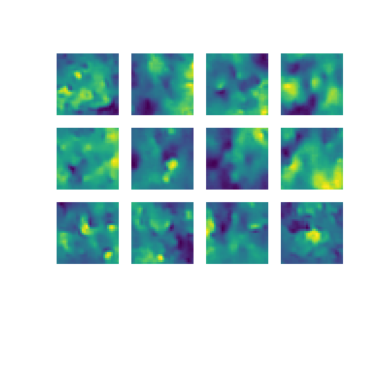

In [ ]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

In [ ]:
model.built = True
model.load_weights("/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/my_model_weights_new_Nocactus_2.h5")

In [ ]:
epoch=100

tf.Tensor(59.245956, shape=(), dtype=float32) tf.Tensor(8.045958, shape=(), dtype=float32) tf.Tensor(51.2, shape=(), dtype=float32)


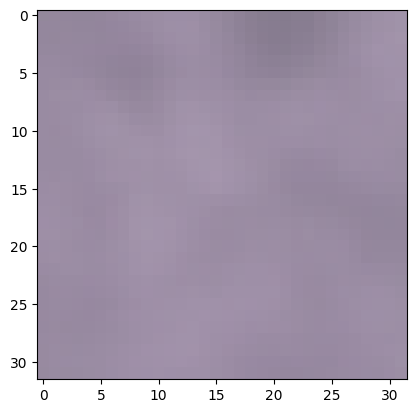

In [ ]:
# test_inputs =test_images[0]
test_inputs =images_1[8]
test_inputs = test_inputs.reshape(1,32,32,3)

# from tf.keras.models import load_model

def check_image(test_inputs,latent_dim):
    loaded_model = model
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    loss_sum, recon_loss, kl_loss, = compute_loss(loaded_model, test_inputs)
    print(loss_sum, recon_loss ,kl_loss)
    img = np.squeeze(img)
    return plt.imshow(img)

img = check_image(test_inputs,1024)

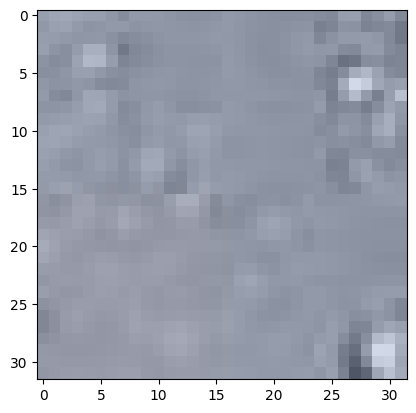

In [ ]:
check_inputs = images_1[8]
plt.imshow(check_inputs)

In [ ]:
# test_inputs =test_images[0]
test_inputs =test_images[100]
test_inputs = test_inputs.reshape(1,32,32,3)

# from tf.keras.models import load_model

def check_image(test_inputs,latent_dim):
    loaded_model = model
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    loss_sum, recon_loss, kl_loss, = compute_loss(loaded_model, test_inputs)
    print(loss_sum, recon_loss ,kl_loss)
    img = np.squeeze(img)
    return plt.imshow(img)

img = check_image(test_inputs,24)

NameError: name 'test_images' is not defined

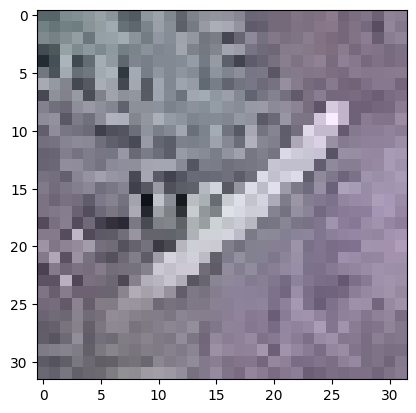

In [ ]:
check_inputs = test_images[100]
plt.imshow(check_inputs)

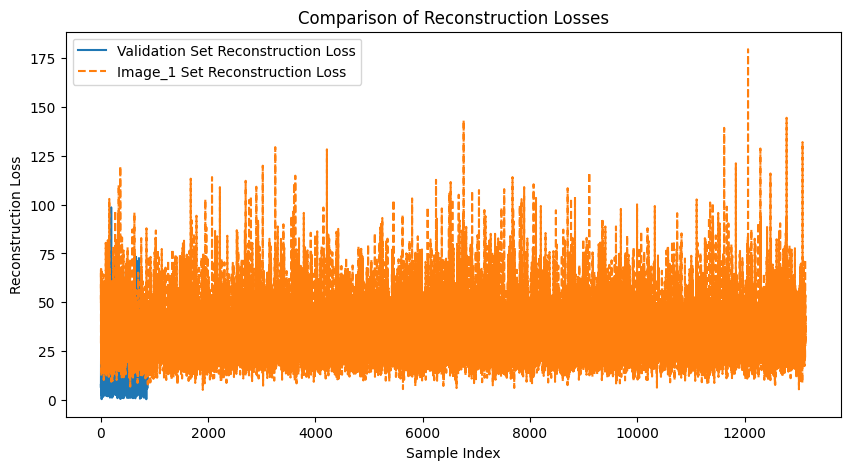

In [ ]:
import matplotlib.pyplot as plt

# Assuming `validation_dataset` and `image_0_dataset` are preprocessed and ready to use
recon_losses_validation = []
recon_losses_image_1 = []

# Compute reconstruction loss for the validation dataset
for test_inputs in test_images:
    test_inputs = test_inputs.reshape(1,32,32,3)
    _, recon_loss,_= compute_loss(model, test_inputs)
    recon_losses_validation.append(recon_loss.numpy())

# Compute reconstruction loss for the image_0 dataset
for test_inputs in images_1:
    test_inputs = test_inputs.reshape(1,32,32,3)
    _, recon_loss,_ = compute_loss(model, test_inputs)
    recon_losses_image_1.append(recon_loss.numpy())

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(recon_losses_validation, label='Validation Set Reconstruction Loss')
plt.plot(recon_losses_image_1, label='Image_1 Set Reconstruction Loss', linestyle='--')
plt.title('Comparison of Reconstruction Losses')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()


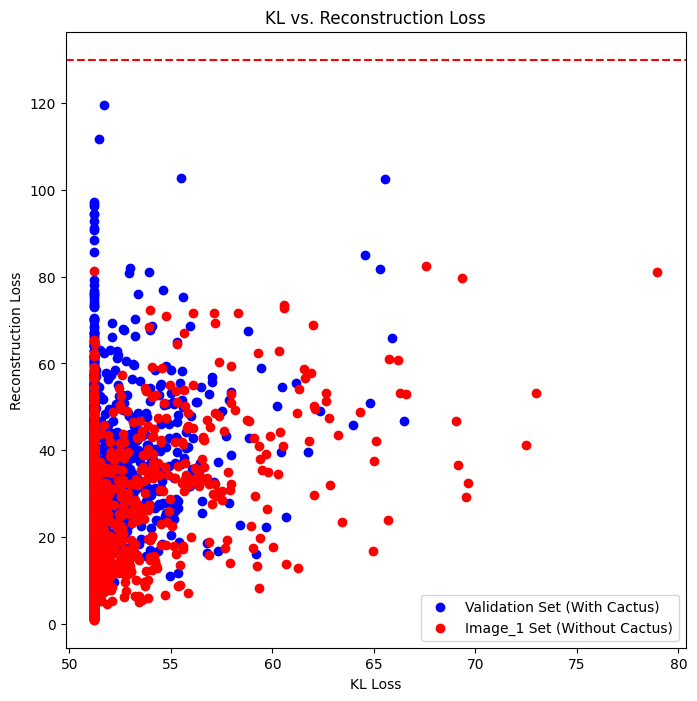

In [ ]:
import matplotlib.pyplot as plt

# Assuming `test_images` and `images_0` are preprocessed and ready to use
recon_losses_validation = []
kl_losses_validation = []
recon_losses_image_1 = []
kl_losses_image_1 = []

# Compute reconstruction and KL loss for the validation dataset
for test_inputs in test_images:
    test_inputs = test_inputs.reshape(1, 32, 32, 3)
    loss_sum, recon_loss, kl_loss = compute_loss(model, test_inputs)
    recon_losses_validation.append(recon_loss.numpy())
    kl_losses_validation.append(kl_loss.numpy())

# Compute reconstruction and KL loss for the image_0 dataset
for test_inputs in images_1:
    test_inputs = test_inputs.reshape(1, 32, 32, 3)
    loss_sum, recon_loss, kl_loss = compute_loss(model, test_inputs)
    recon_losses_image_1.append(recon_loss.numpy())
    kl_losses_image_1.append(kl_loss.numpy())

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=kl_losses_validation, y=recon_losses_validation, color='b', label='Validation Set (With Cactus)')
ax.scatter(x=kl_losses_image_1, y=recon_losses_image_1, color='r', label='Image_1 Set (Without Cactus)')
plt.axhline(y=130, color='r', linestyle='--')  # Example threshold, adjust as needed
plt.title('KL vs. Reconstruction Loss')
plt.xlabel('KL Loss')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate mean and standard deviation for validation dataset
mean_validation = np.mean(recon_losses_validation)
std_dev_validation = np.std(recon_losses_validation)

# Calculate mean and standard deviation for image_0 dataset
mean_image_1 = np.mean(recon_losses_image_1)
std_dev_image_1 = np.std(recon_losses_image_1)

# Print the calculated statistics
print(f"Validation Set - Mean Reconstruction Loss: {mean_validation}, Standard Deviation: {std_dev_validation}")
print(f"Image_1 Set - Mean Reconstruction Loss: {mean_image_1}, Standard Deviation: {std_dev_image_1}")


Validation Set - Mean Reconstruction Loss: 29.07074737548828, Standard Deviation: 13.636369705200195
Image_1 Set - Mean Reconstruction Loss: 14.880741119384766, Standard Deviation: 11.278623580932617


In [ ]:
import pandas as pd

def classify_images_based_on_threshold(dataset, model, threshold, label):
    # List to hold reconstruction losses and predictions
    losses = []
    predictions = []

    # Compute reconstruction loss for the dataset
    for idx, test_inputs in enumerate(dataset):
        test_inputs = test_inputs.reshape(1,32,32,3)
        _, recon_loss,_ = compute_loss(model, test_inputs)
        recon_loss_value = recon_loss.numpy()
        losses.append((idx, recon_loss_value))

        # Classify based on the threshold
        if recon_loss_value > threshold:
            predictions.append((idx, label, 0))  # Predicted as no cactus
        else:
            predictions.append((idx, label, 1))  # Predicted as cactus

    return predictions, losses

# Parameters
threshold = 20

# Classify both datasets
predictions_image_1, losses_image_1 = classify_images_based_on_threshold(images_1,model, threshold, 0)
predictions_validation, losses_validation = classify_images_based_on_threshold(test_images, model, threshold, 1)

# Combine predictions
all_predictions = predictions_image_1 + predictions_validation

# Create DataFrame
df_predictions = pd.DataFrame(all_predictions, columns=['Image Index', 'Actual Class', 'Predicted Class'])
df_predictions


,Image Index,Actual Class,Predicted Class
0,0,0,0
1,1,0,0
2,2,0,1
3,3,0,1
4,4,0,1
...,...,...,...
6987,2623,1,1
6988,2624,1,0
6989,2625,1,0
6990,2626,1,0


In [ ]:
import pandas as pd

def compute_reconstruction_losses(dataset, model):
    losses = []
    for idx, test_inputs in enumerate(dataset):
        test_inputs = test_inputs.reshape(1, 32, 32, 3)  # Ensure input shape matches model's expected input
        _, recon_loss, _ = compute_loss(model, test_inputs)
        recon_loss_value = recon_loss.numpy()
        losses.append((idx, recon_loss_value))
    return losses

def classify_based_on_threshold(losses, threshold, label):
    predictions = []
    for idx, recon_loss_value in losses:
        if recon_loss_value > threshold:
            predictions.append((idx, label, 1))  # Predicted as no cactus
        else:
            predictions.append((idx, label, 0))  # Predicted as cactus
    return predictions

# # Compute losses for both datasets
# losses_image_1 = compute_reconstruction_losses(images_1, model)
# losses_validation = compute_reconstruction_losses(test_images, model)

In [ ]:
# Set the threshold for classification
threshold = 15

# Classify based on the threshold
predictions_image_1 = classify_based_on_threshold(losses_image_1, threshold, 0)
predictions_validation = classify_based_on_threshold(losses_validation, threshold, 1)

# Combine predictions and create a DataFrame
all_predictions = predictions_image_1 + predictions_validation
df_predictions = pd.DataFrame(all_predictions, columns=['Image Index', 'Actual Class', 'Predicted Class'])

df_predictions


,Image Index,Actual Class,Predicted Class
0,0,0,1
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
6987,2623,1,1
6988,2624,1,1
6989,2625,1,1
6990,2626,1,1


In [ ]:
print(len(test_images))
print(len(images_1))

873
13136


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Extract predictions and actual classes
actual_classes = df_predictions['Actual Class'].values
predicted_classes = df_predictions['Predicted Class'].values

# Calculate metrics
accuracy = accuracy_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7346967963386728
Recall: 0.9098173515981736
F1 Score: 0.7205062528250715


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc_valid = matthews_corrcoef(actual_classes, predicted_classes)
# mcc_test = matthews_corrcoef(ground_truths_test, class_predictions_test)
print(f"Matthews Correlation Coefficient:  Validation {mcc_valid}")

Matthews Correlation Coefficient:  Validation 0.4814459270253289


In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_valid = balanced_accuracy_score(actual_classes, predicted_classes)
# balanced_accuracy_test = balanced_accuracy_score(ground_truths_test, class_predictions_test)

print(f"Balanced Accuracy: Valid {balanced_accuracy_valid}")

Balanced Accuracy: Valid 0.8154718615579302
